# Description

This notebook looks at the 'recordings' folder and summarizes what's there.

1. what sessions have behavioral and neural recordings?
2. what sessions has **valid** behavioral files.

In [1]:
##% imports
import os
import pandas as pd
import numpy as np

from popy.io_tools import get_behavior, load_raw_behav_mat
import popy.config as cfg

In [2]:
##% data manup functions

def extract_session_info(path):
    """
    This function extracts the session info from the behav files.
    It returns with a pandas dataframe with the following columns:
    
    monkey: monkey name, str
    recording_day: date of the recording, np.datetime64
    session: session id, str
    position: position of the recording, str
    depth: depth of the recording, str
    session_of_day: session of the day, str
    behav_file_name: name of the behav file with extension, str
    """
    all_file_names = os.listdir(path)

    recs_df = []
    for file_name in all_file_names:
        session_dict = {}
        if file_name.split('.')[-1] == 'mat':
            session_dict["monkey"] = file_name[:2]

            session = file_name[2:8]
            session_dict['recording_day'] = convert_sess_to_date(session)
            session_dict["session"] = session
            
            depth_and_sess_of_day = file_name.split("_")[2].split('.')[0]
            session_dict["depth"] = depth_and_sess_of_day[:4]
            session_dict["session_of_day"] = depth_and_sess_of_day[4:]

            session_dict["block_len_valid"] = np.nan
            session_dict["n_blocks"] = np.nan

            # position is encoded as 'abcd', where 
            # a: MCC x position, b: MCC y position, c: LPFC x position, d: LPFC y position
            # but sometimes there is no MCC or no LPFC recording, in this case the position is encoded as 'ab' or 'cd'
            # but we can only see later which...
            position = file_name.split("_")[1]
            if len(position) == 4:  
                pos_mcc = position[:2]
                pos_lpfc = position[2:]
            else:
                pos_mcc = np.nan
                pos_lpfc = np.nan

            session_dict["position_MCC"] = pos_mcc
            session_dict['coords_MCC'] = np.nan
            session_dict["position_LPFC"] = pos_lpfc
            session_dict['coords_LPFC'] = np.nan

            session_dict['LPFC_subregion'] = np.nan
            
            session_dict['MCC_spikes_exist'] = False
            session_dict['MCC_file_name'] = np.nan

            session_dict['LPFC_spikes_exist'] = False
            session_dict['LPFC_file_name'] = np.nan

            session_dict["behav_file_name"] = file_name

            recs_df.append(session_dict)

    recs_df = pd.DataFrame(recs_df).sort_values(['monkey', 'recording_day'])
    return recs_df.reset_index(drop=True)


def convert_sess_to_date(session_id):
    d, m, y = session_id[:2], session_id[2:4], session_id[4:]
    return np.datetime64(f'20{y}-{m}-{d}')


def check_neural_files(recs_df, path):
    for file_name in os.listdir(path):
        session_dict = {}

        area = file_name.split("_")[2]
        monkey = file_name.split("_")[3][:2]
        session = file_name.split("_")[3][2:8]
        session_of_the_day = file_name.split("_")[4][:3]

        # check if this (monkey, session) pair is in the df
        if len(recs_df.loc[(recs_df['monkey'] == monkey) & (recs_df['session'] == session)]) == 0:
            print(f'no behavior for {monkey} {session} {area}')
            continue

        # append data to row where session and session of the day match
        recs_df.loc[(recs_df['monkey'] == monkey) & (recs_df['session'] == session) & (recs_df['session_of_day'] == session_of_the_day),
                    f'{area}_spikes_exist'] = True

        recs_df.loc[(recs_df['monkey'] == monkey) & (recs_df['session'] == session) & (recs_df['session_of_day'] == session_of_the_day),
                    f'{area}_file_name'] = file_name

    return recs_df


def fill_nan_recs(recs_df):
    for i, row in recs_df.iterrows():
        area_code = row['behav_file_name'].split("_")[1]
        len_area_code = len(area_code)
        LPFC_exists = row['LPFC_spikes_exist']
        MCC_exists = row['MCC_spikes_exist']

        #if len_area_code == 2 & LPFC_exists & not MCC_exists
        if len_area_code == 2 and LPFC_exists and (not MCC_exists):
            recs_df.loc[i, 'position_LPFC'] = area_code
            print(f'LPFC added - {row.monkey} {row.session}')
        elif len_area_code == 2 & (not LPFC_exists) & MCC_exists:
            recs_df.loc[i, 'position_MCC'] = area_code
            print(f'MCC added - {row.monkey} {row.session}')

    return recs_df


def add_coordinates(recs_df):
    decode_first_pos = {'a': 9, 'b': 8, 'c': 7, 'd': 6, 'e': 5, 'f': 4, 'g': 3, 'h': 2, 'i': 1, 'j': 0, 'k': -1, 'l': -2, 'm': -3, 'n': -4, 'o': -5, 'p': -6, 'q': -7, 'r': -8, 's': -9}
    decode_second_pos = {'a': -9, 'b': -8, 'c': -7, 'd': -6, 'e': -5, 'f': -4, 'g': -3, 'h': -2, 'i': -1, 'j': 0, 'k': 1, 'l': 2, 'm': 3, 'n': 4, 'o': 5, 'p': 6, 'q': 7, 'r': 8, 's': 9}

    coords = {'MCC': [], 'LPFC': []}
    for i, row in recs_df.iterrows():
        pos_MCC = row['position_MCC']
        if not pd.isna(pos_MCC):
            coords["MCC"].append((decode_first_pos[pos_MCC[0]], decode_second_pos[pos_MCC[1]]))
        else:
            coords["MCC"].append(np.nan)

        pos_LPFC = row['position_LPFC']
        if not pd.isna(pos_LPFC):
            coords["LPFC"].append((decode_first_pos[pos_LPFC[0]], decode_second_pos[pos_LPFC[1]]))
        else:
            coords["LPFC"].append(np.nan)

    # add the coordinates to the dataframe (the 'coords_MCC' after the column 'position_MCC', and 'coords_LPFC' after the column 'position_LPFC')
    recs_df['coords_MCC'] = coords['MCC']
    recs_df['coords_LPFC'] = coords['LPFC']

    return recs_df


def is_file_valid(behav):
    """
    Tries to find errors in the behaviour data. Returns True if no errors were found, False otherwise. However, it is not guaranteed that the function will find all errors.
    """
    locs_trial_start = np.argwhere(behav[:, 0] == 100)
    locs_trial_end = np.argwhere(behav[:, 0] == 101)

    # trial starts NOT equal to trial ends
    if len(locs_trial_start) != len(locs_trial_end):
        print('Num trial start events s not equal to num trial end events')
        if locs_trial_start[0][0] > locs_trial_end[0][0]:
            print('\tperhaps missing first trial start')
        if locs_trial_end[-1][0] < locs_trial_start[-1][0]:
            print('\tperhaps missing last trial end')

        # trial ends should be followed by trial starts, except when it if a block end (in this case there are 2 excess values in between)
        for start_id in locs_trial_start[1:]:  # ignore first one as it has no previous
            start_id = start_id[0]
            if not (behav[start_id - 1, 0] == 101 or behav[start_id - 3, 0] == 101):
                print('\tmissing trial end at: ', start_id)
        for end_id in locs_trial_end[:-1] :  # ignore last one as it has no following
            end_id = end_id[0]
            if not (behav[end_id + 1, 0] == 100 or behav[end_id + 3, 0] == 100):
                print('\tmissing trial start at: ', end_id)

        return False

    for start_id, end_id in zip(locs_trial_start, locs_trial_end):
        start_id, end_id = start_id[0], end_id[0]
        # behav of current trial
        behav_curr = behav[start_id:end_id+1, 0]

        # num events
        all_events = {
            'N_trial_start': np.count_nonzero(behav_curr == 100),
            'N_lever_val': np.count_nonzero(behav_curr == 62),
            'N_lever_release': np.count_nonzero(behav_curr == 64),
            'N_target_valid': np.count_nonzero(behav_curr== 125),
            'N_fb': np.count_nonzero((behav_curr == 65) | (behav_curr == 66)),
            'N_trial_end': np.count_nonzero(behav_curr == 101),
            'N_no_touch': np.count_nonzero(behav_curr == 252)
        }

        # is there a value in all_events higher than 1?
        if np.any(np.array(list(all_events.values())) > 1):
            multiples = np.argwhere(np.array(list(all_events.values())) > 1)
            print(f'corrupt trial between index {start_id} and {end_id}')
            print(f'\tmultiple behav code for {np.array(list(all_events.keys()))[multiples]}')
            return False

        # when there is not a 'no touch' event, i.e. correct trial
        if all_events['N_no_touch'] == 0:
            N_events = np.array(list(all_events.values()))[:-1] # all events - remove last element (N_no_touch)
            if all([x == 1 for x in N_events]):  # all events must be 1, in this case its a correct trial
                continue 
            else:
                # is there any value of 0?
                zeros = np.argwhere(N_events == 0)
                print(f'corrupt trial between index {start_id} and {end_id}')
                print(f'\tmissing behav code for {np.array(list(all_events.keys()))[zeros]}')
                return False
        else:  # in case there is a 'no touch' event, i.e. incorrect trial
            N_events = np.array(list(all_events.values()))[:-2]  # all events - remove last 2 elements (N_no_touch, N_trial_end)
            # is the ordering right?
            ordering_right = [x >= y for x, y in zip(N_events[:-1], N_events[1:])]
            if all(ordering_right):
                continue
            else:
                print(f'corrupt trial between index {start_id} and {end_id}')
                print('there is a no touch event, but something is missing from before')
                return False
            
    # if it didnt find an error, return True
    return True


def add_subregion(recs_df):
    """
    This function adds a new column to the dataframe with the subregion of the LPFC recording.
    The subregion is determined by the coordinates of the recording.
    The coordinates are in the form of (x, y), where x and y are integers.
    The subregions are defined as follows
    """
    
    dlpfc_subregions = {
        'ka': [(-5, -2),
            (-6, -2), 
            (-6, -4), 
            (-6, -5), 
            (-6, -6), 
            (-6, -7),
            (-7, -3),
            (-7, -4),
            (-7, -5),
            (-7, -6)],
        'po': [(-6, -6),
            (-6, -7), 
            (-7, -5),
            (-7, -7),
            (-7, -8), 
            (-8, -6),]
    }

    # some of the dlpfc coordinates are also in the mcc coordinates, so we need to remove them
    mcc_subregions = {
        'ka': [(5, 3)],
        'po': [(0, 5)]
    }

    subregions = []
    for i, row in recs_df.iterrows():
        coords_LPFC = row['coords_LPFC']
        monkey = row['monkey']
        if not pd.isna(coords_LPFC):
            if coords_LPFC in mcc_subregions[monkey]:
                subregion = 'MCC'
            elif coords_LPFC in dlpfc_subregions[monkey]:
                subregion = 'dLPFC'
            else:
                subregion = 'vLPFC'
        else:
            subregion = np.nan

        subregions.append(subregion)

    recs_df['LPFC_subregion'] = subregions

    return recs_df


def get_block_len_valid(recs_df):
    for index, row in recs_df.iterrows():
        try:
            session_data = get_behavior(row['monkey'], row['session'])

            # number of blocks
            recs_df.loc[index, 'n_blocks'] = len(session_data.block_id.unique())

            # check if the session is valid
            block_len = session_data.groupby('block_id').size().values.mean()
            if block_len > 35:
                recs_df.loc[index, 'block_len_valid'] = True
            else:
                recs_df.loc[index, 'block_len_valid'] = False
        except:
            recs_df.loc[index, 'block_len_valid'] = np.nan
            continue

    return recs_df


def get_session_valid(recs_df):
    for index, row in recs_df.iterrows():
        monkey, session = row['monkey'], row['session']

        # get raw behav file
        rec = load_raw_behav_mat(monkey, session, folder_path=os.path.join(RAW_DATA_PATH, 'behavior'))
        any_interrupted_trials = np.count_nonzero(rec[:, 0 ]== 252)  # count number of trials when the monkey stopped
        is_session_complete = np.count_nonzero(rec[:, 0] == 102) == 1  # check if the session has an ending

        recs_df.loc[recs_df['session'] == row['session'], 'interrupted_trials'] = any_interrupted_trials
        recs_df.loc[recs_df['session'] == row['session'], 'session_complete'] = is_session_complete
    
    return recs_df



# Step 1: Process

## Behavior

In [3]:
# define paths
RAW_DATA_PATH = os.path.join(cfg.PROJECT_PATH_LOCAL, 'data', 'recordings')

# extract session info from all sessions in the target folder
recs_df = extract_session_info(os.path.join(RAW_DATA_PATH, 'behavior'))
recs_df

,monkey,recording_day,session,depth,session_of_day,block_len_valid,n_blocks,position_MCC,coords_MCC,position_LPFC,coords_LPFC,LPFC_subregion,MCC_spikes_exist,MCC_file_name,LPFC_spikes_exist,LPFC_file_name,behav_file_name
0,ka,2020-05-23,230520,7042,001,NaN,NaN,gm,NaN,ki,NaN,NaN,False,NaN,False,NaN,ka230520_gmki_7042001.mat
1,ka,2020-06-05,050620,6914,002,NaN,NaN,ej,NaN,jf,NaN,NaN,False,NaN,False,NaN,ka050620_ejjf_6914002.mat
2,ka,2020-06-08,080620,7621,003,NaN,NaN,fn,NaN,kh,NaN,NaN,False,NaN,False,NaN,ka080620_fnkh_7621003.mat
3,ka,2020-06-10,100620,7639,001,NaN,NaN,el,NaN,lg,NaN,NaN,False,NaN,False,NaN,ka100620_ellg_7639001.mat
4,ka,2020-06-16,160620,8565,001,NaN,NaN,go,NaN,lj,NaN,NaN,False,NaN,False,NaN,ka160620_golj_8565001.mat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,po,2022-07-20,200722,5782,002,NaN,NaN,di,NaN,le,NaN,NaN,False,NaN,False,NaN,po200722_dile_5782002.mat
125,po,2022-07-28,280722,5869,002,NaN,NaN,gh,NaN,pg,NaN,NaN,False,NaN,False,NaN,po280722_ghpg_5869002.mat
126,po,2022-08-09,090822,5184,003,NaN,NaN,gp,NaN,ne,NaN,NaN,False,NaN,False,NaN,po090822_gpne_5184003.mat
127,po,2022-08-31,310822,5522,001,NaN,NaN,gj,NaN,ld,NaN,NaN,False,NaN,False,NaN,po310822_gjld_5522001.mat


## Neural data

In [4]:
#%% Checking if the spike sorting had been already done for each session
recs_df = check_neural_files(recs_df, os.path.join(RAW_DATA_PATH, 'neural_data'))
recs_df

no behavior for ka 310522 LPFC


,monkey,recording_day,session,depth,session_of_day,block_len_valid,n_blocks,position_MCC,coords_MCC,position_LPFC,coords_LPFC,LPFC_subregion,MCC_spikes_exist,MCC_file_name,LPFC_spikes_exist,LPFC_file_name,behav_file_name
0,ka,2020-05-23,230520,7042,001,NaN,NaN,gm,NaN,ki,NaN,NaN,True,spk_dataset_MCC_ka230520_001.txt,False,NaN,ka230520_gmki_7042001.mat
1,ka,2020-06-05,050620,6914,002,NaN,NaN,ej,NaN,jf,NaN,NaN,True,spk_dataset_MCC_ka050620_002.txt,True,spk_dataset_LPFC_ka050620_002.txt,ka050620_ejjf_6914002.mat
2,ka,2020-06-08,080620,7621,003,NaN,NaN,fn,NaN,kh,NaN,NaN,True,spk_dataset_MCC_ka080620_003.txt,True,spk_dataset_LPFC_ka080620_003.txt,ka080620_fnkh_7621003.mat
3,ka,2020-06-10,100620,7639,001,NaN,NaN,el,NaN,lg,NaN,NaN,True,spk_dataset_MCC_ka100620_001.txt,True,spk_dataset_LPFC_ka100620_001.txt,ka100620_ellg_7639001.mat
4,ka,2020-06-16,160620,8565,001,NaN,NaN,go,NaN,lj,NaN,NaN,True,spk_dataset_MCC_ka160620_001.txt,True,spk_dataset_LPFC_ka160620_001.txt,ka160620_golj_8565001.mat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,po,2022-07-20,200722,5782,002,NaN,NaN,di,NaN,le,NaN,NaN,True,spk_dataset_MCC_po200722_002.txt,True,spk_dataset_LPFC_po200722_002.txt,po200722_dile_5782002.mat
125,po,2022-07-28,280722,5869,002,NaN,NaN,gh,NaN,pg,NaN,NaN,True,spk_dataset_MCC_po280722_002.txt,True,spk_dataset_LPFC_po280722_002.txt,po280722_ghpg_5869002.mat
126,po,2022-08-09,090822,5184,003,NaN,NaN,gp,NaN,ne,NaN,NaN,True,spk_dataset_MCC_po090822_003.txt,True,spk_dataset_LPFC_po090822_003.txt,po090822_gpne_5184003.mat
127,po,2022-08-31,310822,5522,001,NaN,NaN,gj,NaN,ld,NaN,NaN,True,spk_dataset_MCC_po310822_001.txt,True,spk_dataset_LPFC_po310822_001.txt,po310822_gjld_5522001.mat


## Complete position codes

Sometimes there is only one area'sper recording. Complete the position column to know which area is it.

In [5]:
# get rows with nan at column 'LPFC_spikes_exist' or 'MCC_spikes_exist'
recs_df = fill_nan_recs(recs_df)
recs_df

LPFC added - ka 090720
LPFC added - po 070920


,monkey,recording_day,session,depth,session_of_day,block_len_valid,n_blocks,position_MCC,coords_MCC,position_LPFC,coords_LPFC,LPFC_subregion,MCC_spikes_exist,MCC_file_name,LPFC_spikes_exist,LPFC_file_name,behav_file_name
0,ka,2020-05-23,230520,7042,001,NaN,NaN,gm,NaN,ki,NaN,NaN,True,spk_dataset_MCC_ka230520_001.txt,False,NaN,ka230520_gmki_7042001.mat
1,ka,2020-06-05,050620,6914,002,NaN,NaN,ej,NaN,jf,NaN,NaN,True,spk_dataset_MCC_ka050620_002.txt,True,spk_dataset_LPFC_ka050620_002.txt,ka050620_ejjf_6914002.mat
2,ka,2020-06-08,080620,7621,003,NaN,NaN,fn,NaN,kh,NaN,NaN,True,spk_dataset_MCC_ka080620_003.txt,True,spk_dataset_LPFC_ka080620_003.txt,ka080620_fnkh_7621003.mat
3,ka,2020-06-10,100620,7639,001,NaN,NaN,el,NaN,lg,NaN,NaN,True,spk_dataset_MCC_ka100620_001.txt,True,spk_dataset_LPFC_ka100620_001.txt,ka100620_ellg_7639001.mat
4,ka,2020-06-16,160620,8565,001,NaN,NaN,go,NaN,lj,NaN,NaN,True,spk_dataset_MCC_ka160620_001.txt,True,spk_dataset_LPFC_ka160620_001.txt,ka160620_golj_8565001.mat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,po,2022-07-20,200722,5782,002,NaN,NaN,di,NaN,le,NaN,NaN,True,spk_dataset_MCC_po200722_002.txt,True,spk_dataset_LPFC_po200722_002.txt,po200722_dile_5782002.mat
125,po,2022-07-28,280722,5869,002,NaN,NaN,gh,NaN,pg,NaN,NaN,True,spk_dataset_MCC_po280722_002.txt,True,spk_dataset_LPFC_po280722_002.txt,po280722_ghpg_5869002.mat
126,po,2022-08-09,090822,5184,003,NaN,NaN,gp,NaN,ne,NaN,NaN,True,spk_dataset_MCC_po090822_003.txt,True,spk_dataset_LPFC_po090822_003.txt,po090822_gpne_5184003.mat
127,po,2022-08-31,310822,5522,001,NaN,NaN,gj,NaN,ld,NaN,NaN,True,spk_dataset_MCC_po310822_001.txt,True,spk_dataset_LPFC_po310822_001.txt,po310822_gjld_5522001.mat


## Add coordinates

In [6]:
recs_df = add_coordinates(recs_df)
recs_df

,monkey,recording_day,session,depth,session_of_day,block_len_valid,n_blocks,position_MCC,coords_MCC,position_LPFC,coords_LPFC,LPFC_subregion,MCC_spikes_exist,MCC_file_name,LPFC_spikes_exist,LPFC_file_name,behav_file_name
0,ka,2020-05-23,230520,7042,001,NaN,NaN,gm,"(3, 3)",ki,"(-1, -1)",NaN,True,spk_dataset_MCC_ka230520_001.txt,False,NaN,ka230520_gmki_7042001.mat
1,ka,2020-06-05,050620,6914,002,NaN,NaN,ej,"(5, 0)",jf,"(0, -4)",NaN,True,spk_dataset_MCC_ka050620_002.txt,True,spk_dataset_LPFC_ka050620_002.txt,ka050620_ejjf_6914002.mat
2,ka,2020-06-08,080620,7621,003,NaN,NaN,fn,"(4, 4)",kh,"(-1, -2)",NaN,True,spk_dataset_MCC_ka080620_003.txt,True,spk_dataset_LPFC_ka080620_003.txt,ka080620_fnkh_7621003.mat
3,ka,2020-06-10,100620,7639,001,NaN,NaN,el,"(5, 2)",lg,"(-2, -3)",NaN,True,spk_dataset_MCC_ka100620_001.txt,True,spk_dataset_LPFC_ka100620_001.txt,ka100620_ellg_7639001.mat
4,ka,2020-06-16,160620,8565,001,NaN,NaN,go,"(3, 5)",lj,"(-2, 0)",NaN,True,spk_dataset_MCC_ka160620_001.txt,True,spk_dataset_LPFC_ka160620_001.txt,ka160620_golj_8565001.mat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,po,2022-07-20,200722,5782,002,NaN,NaN,di,"(6, -1)",le,"(-2, -5)",NaN,True,spk_dataset_MCC_po200722_002.txt,True,spk_dataset_LPFC_po200722_002.txt,po200722_dile_5782002.mat
125,po,2022-07-28,280722,5869,002,NaN,NaN,gh,"(3, -2)",pg,"(-6, -3)",NaN,True,spk_dataset_MCC_po280722_002.txt,True,spk_dataset_LPFC_po280722_002.txt,po280722_ghpg_5869002.mat
126,po,2022-08-09,090822,5184,003,NaN,NaN,gp,"(3, 6)",ne,"(-4, -5)",NaN,True,spk_dataset_MCC_po090822_003.txt,True,spk_dataset_LPFC_po090822_003.txt,po090822_gpne_5184003.mat
127,po,2022-08-31,310822,5522,001,NaN,NaN,gj,"(3, 0)",ld,"(-2, -6)",NaN,True,spk_dataset_MCC_po310822_001.txt,True,spk_dataset_LPFC_po310822_001.txt,po310822_gjld_5522001.mat


## Add LPFC subregion

In [7]:
recs_df = add_subregion(recs_df)
recs_df


,monkey,recording_day,session,depth,session_of_day,block_len_valid,n_blocks,position_MCC,coords_MCC,position_LPFC,coords_LPFC,LPFC_subregion,MCC_spikes_exist,MCC_file_name,LPFC_spikes_exist,LPFC_file_name,behav_file_name
0,ka,2020-05-23,230520,7042,001,NaN,NaN,gm,"(3, 3)",ki,"(-1, -1)",vLPFC,True,spk_dataset_MCC_ka230520_001.txt,False,NaN,ka230520_gmki_7042001.mat
1,ka,2020-06-05,050620,6914,002,NaN,NaN,ej,"(5, 0)",jf,"(0, -4)",vLPFC,True,spk_dataset_MCC_ka050620_002.txt,True,spk_dataset_LPFC_ka050620_002.txt,ka050620_ejjf_6914002.mat
2,ka,2020-06-08,080620,7621,003,NaN,NaN,fn,"(4, 4)",kh,"(-1, -2)",vLPFC,True,spk_dataset_MCC_ka080620_003.txt,True,spk_dataset_LPFC_ka080620_003.txt,ka080620_fnkh_7621003.mat
3,ka,2020-06-10,100620,7639,001,NaN,NaN,el,"(5, 2)",lg,"(-2, -3)",vLPFC,True,spk_dataset_MCC_ka100620_001.txt,True,spk_dataset_LPFC_ka100620_001.txt,ka100620_ellg_7639001.mat
4,ka,2020-06-16,160620,8565,001,NaN,NaN,go,"(3, 5)",lj,"(-2, 0)",vLPFC,True,spk_dataset_MCC_ka160620_001.txt,True,spk_dataset_LPFC_ka160620_001.txt,ka160620_golj_8565001.mat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,po,2022-07-20,200722,5782,002,NaN,NaN,di,"(6, -1)",le,"(-2, -5)",vLPFC,True,spk_dataset_MCC_po200722_002.txt,True,spk_dataset_LPFC_po200722_002.txt,po200722_dile_5782002.mat
125,po,2022-07-28,280722,5869,002,NaN,NaN,gh,"(3, -2)",pg,"(-6, -3)",vLPFC,True,spk_dataset_MCC_po280722_002.txt,True,spk_dataset_LPFC_po280722_002.txt,po280722_ghpg_5869002.mat
126,po,2022-08-09,090822,5184,003,NaN,NaN,gp,"(3, 6)",ne,"(-4, -5)",vLPFC,True,spk_dataset_MCC_po090822_003.txt,True,spk_dataset_LPFC_po090822_003.txt,po090822_gpne_5184003.mat
127,po,2022-08-31,310822,5522,001,NaN,NaN,gj,"(3, 0)",ld,"(-2, -6)",vLPFC,True,spk_dataset_MCC_po310822_001.txt,True,spk_dataset_LPFC_po310822_001.txt,po310822_gjld_5522001.mat


## Behav files valid?

checks for interrupted trials and missing session ends

In [8]:
# loop through sessions


recs_df = get_session_valid(recs_df)
recs_df

,monkey,recording_day,session,depth,session_of_day,block_len_valid,n_blocks,position_MCC,coords_MCC,position_LPFC,coords_LPFC,LPFC_subregion,MCC_spikes_exist,MCC_file_name,LPFC_spikes_exist,LPFC_file_name,behav_file_name,interrupted_trials,session_complete
0,ka,2020-05-23,230520,7042,001,NaN,NaN,gm,"(3, 3)",ki,"(-1, -1)",vLPFC,True,spk_dataset_MCC_ka230520_001.txt,False,NaN,ka230520_gmki_7042001.mat,1.0,True
1,ka,2020-06-05,050620,6914,002,NaN,NaN,ej,"(5, 0)",jf,"(0, -4)",vLPFC,True,spk_dataset_MCC_ka050620_002.txt,True,spk_dataset_LPFC_ka050620_002.txt,ka050620_ejjf_6914002.mat,0.0,True
2,ka,2020-06-08,080620,7621,003,NaN,NaN,fn,"(4, 4)",kh,"(-1, -2)",vLPFC,True,spk_dataset_MCC_ka080620_003.txt,True,spk_dataset_LPFC_ka080620_003.txt,ka080620_fnkh_7621003.mat,1.0,False
3,ka,2020-06-10,100620,7639,001,NaN,NaN,el,"(5, 2)",lg,"(-2, -3)",vLPFC,True,spk_dataset_MCC_ka100620_001.txt,True,spk_dataset_LPFC_ka100620_001.txt,ka100620_ellg_7639001.mat,0.0,True
4,ka,2020-06-16,160620,8565,001,NaN,NaN,go,"(3, 5)",lj,"(-2, 0)",vLPFC,True,spk_dataset_MCC_ka160620_001.txt,True,spk_dataset_LPFC_ka160620_001.txt,ka160620_golj_8565001.mat,1.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,po,2022-07-20,200722,5782,002,NaN,NaN,di,"(6, -1)",le,"(-2, -5)",vLPFC,True,spk_dataset_MCC_po200722_002.txt,True,spk_dataset_LPFC_po200722_002.txt,po200722_dile_5782002.mat,0.0,True
125,po,2022-07-28,280722,5869,002,NaN,NaN,gh,"(3, -2)",pg,"(-6, -3)",vLPFC,True,spk_dataset_MCC_po280722_002.txt,True,spk_dataset_LPFC_po280722_002.txt,po280722_ghpg_5869002.mat,1.0,True
126,po,2022-08-09,090822,5184,003,NaN,NaN,gp,"(3, 6)",ne,"(-4, -5)",vLPFC,True,spk_dataset_MCC_po090822_003.txt,True,spk_dataset_LPFC_po090822_003.txt,po090822_gpne_5184003.mat,0.0,True
127,po,2022-08-31,310822,5522,001,NaN,NaN,gj,"(3, 0)",ld,"(-2, -6)",vLPFC,True,spk_dataset_MCC_po310822_001.txt,True,spk_dataset_LPFC_po310822_001.txt,po310822_gjld_5522001.mat,2.0,True


## Block length valid

In some sessions, blocks are shorter then 40 +- 5 trials. Mark these ase invalid.

In [9]:
recs_df = get_block_len_valid(recs_df)
recs_df

,monkey,recording_day,session,depth,session_of_day,block_len_valid,n_blocks,position_MCC,coords_MCC,position_LPFC,coords_LPFC,LPFC_subregion,MCC_spikes_exist,MCC_file_name,LPFC_spikes_exist,LPFC_file_name,behav_file_name,interrupted_trials,session_complete
0,ka,2020-05-23,230520,7042,001,True,10.0,gm,"(3, 3)",ki,"(-1, -1)",vLPFC,True,spk_dataset_MCC_ka230520_001.txt,False,NaN,ka230520_gmki_7042001.mat,1.0,True
1,ka,2020-06-05,050620,6914,002,True,7.0,ej,"(5, 0)",jf,"(0, -4)",vLPFC,True,spk_dataset_MCC_ka050620_002.txt,True,spk_dataset_LPFC_ka050620_002.txt,ka050620_ejjf_6914002.mat,0.0,True
2,ka,2020-06-08,080620,7621,003,True,9.0,fn,"(4, 4)",kh,"(-1, -2)",vLPFC,True,spk_dataset_MCC_ka080620_003.txt,True,spk_dataset_LPFC_ka080620_003.txt,ka080620_fnkh_7621003.mat,1.0,False
3,ka,2020-06-10,100620,7639,001,True,10.0,el,"(5, 2)",lg,"(-2, -3)",vLPFC,True,spk_dataset_MCC_ka100620_001.txt,True,spk_dataset_LPFC_ka100620_001.txt,ka100620_ellg_7639001.mat,0.0,True
4,ka,2020-06-16,160620,8565,001,True,10.0,go,"(3, 5)",lj,"(-2, 0)",vLPFC,True,spk_dataset_MCC_ka160620_001.txt,True,spk_dataset_LPFC_ka160620_001.txt,ka160620_golj_8565001.mat,1.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,po,2022-07-20,200722,5782,002,True,9.0,di,"(6, -1)",le,"(-2, -5)",vLPFC,True,spk_dataset_MCC_po200722_002.txt,True,spk_dataset_LPFC_po200722_002.txt,po200722_dile_5782002.mat,0.0,True
125,po,2022-07-28,280722,5869,002,True,11.0,gh,"(3, -2)",pg,"(-6, -3)",vLPFC,True,spk_dataset_MCC_po280722_002.txt,True,spk_dataset_LPFC_po280722_002.txt,po280722_ghpg_5869002.mat,1.0,True
126,po,2022-08-09,090822,5184,003,True,7.0,gp,"(3, 6)",ne,"(-4, -5)",vLPFC,True,spk_dataset_MCC_po090822_003.txt,True,spk_dataset_LPFC_po090822_003.txt,po090822_gpne_5184003.mat,0.0,True
127,po,2022-08-31,310822,5522,001,True,10.0,gj,"(3, 0)",ld,"(-2, -6)",vLPFC,True,spk_dataset_MCC_po310822_001.txt,True,spk_dataset_LPFC_po310822_001.txt,po310822_gjld_5522001.mat,2.0,True


In [10]:
# find if the LPFC is in the vLPFC or dLPFC
'''
def plot_recording_sites(recs_df):
    import matplotlib.pyplot as plt
    from popy.plotting.plot_cortical_grid import _init_location_grid, _plot_matrix

    for monkey, df_monkey in recs_df.groupby('monkey'):
        # get the data for the current monkey
        cm_to_in = 1/2.54
        fig, ax = plt.subplots(1, 1, figsize=(10*cm_to_in, 12*cm_to_in))

        # init grid 
        grid = _init_location_grid()
        
        # get the data for the current monkey, set it to the grid value
        locs_already_used = set()
        
        for session, df_session in df_monkey.groupby('session'):
            for area in ['MCC', 'LPFC']:
                if area == 'MCC':
                    cmap = 'Greens'
                elif  df_session['LPFC_subregion'].values[0] == 'dLPFC':
                    cmap = 'Blues'
                else:
                    cmap = 'Reds'

                # get grid location
                position = df_session[f'position_{area}'].values[0]

                if pd.isna(position):
                    print(f"No position information for recording: monkey {monkey}, session {session}, area {area}")
                    continue

                decode_first_pos = {'a': 9, 'b': 8, 'c': 7, 'd': 6, 'e': 5, 'f': 4, 'g': 3, 'h': 2, 'i': 1, 'j': 0, 'k': -1, 'l': -2, 'm': -3, 'n': -4, 'o': -5, 'p': -6, 'q': -7, 'r': -8, 's': -9}
                decode_second_pos = {'a': -9, 'b': -8, 'c': -7, 'd': -6, 'e': -5, 'f': -4, 'g': -3, 'h': -2, 'i': -1, 'j': 0, 'k': 1, 'l': 2, 'm': 3, 'n': 4, 'o': 5, 'p': 6, 'q': 7, 'r': 8, 's': 9}

                x = decode_first_pos[position[0]]
                y = decode_second_pos[position[1]]

                #print(f'session: {session}, area: {area}, x: {x}, y: {y}')

                # add to the grid (if the location is not already used, esle use the better value)
                value_to_show = 1
                if (x, y) not in locs_already_used:
                    #print(f"+ Adding ({x}, {y}) to the grid")
                    grid.loc[dict(x=x, y=y)] = value_to_show
                    locs_already_used.add((x, y))
                else:  # use the higher value
                    #print(f"    - Location ({x}, {y}) already used, adding to the grid")
                    grid.loc[dict(x=x, y=y)] = np.sum((value_to_show, grid.loc[dict(x=x, y=y)]))

        # plot the grid on the subplot
        _plot_matrix(grid, monkey, ax=ax, title=f"Monkey {monkey.upper()} vLPFC", label='# sessions', print_values=True, vmin=0)
        plt.tight_layout()
        plt.show()

'''

'\ndef plot_recording_sites(recs_df):\n    import matplotlib.pyplot as plt\n    from popy.plotting.plot_cortical_grid import _init_location_grid, _plot_matrix\n\n    for monkey, df_monkey in recs_df.groupby(\'monkey\'):\n        # get the data for the current monkey\n        cm_to_in = 1/2.54\n        fig, ax = plt.subplots(1, 1, figsize=(10*cm_to_in, 12*cm_to_in))\n\n        # init grid \n        grid = _init_location_grid()\n        \n        # get the data for the current monkey, set it to the grid value\n        locs_already_used = set()\n        \n        for session, df_session in df_monkey.groupby(\'session\'):\n            for area in [\'MCC\', \'LPFC\']:\n                if area == \'MCC\':\n                    cmap = \'Greens\'\n                elif  df_session[\'LPFC_subregion\'].values[0] == \'dLPFC\':\n                    cmap = \'Blues\'\n                else:\n                    cmap = \'Reds\'\n\n                # get grid location\n                position = df_sessio

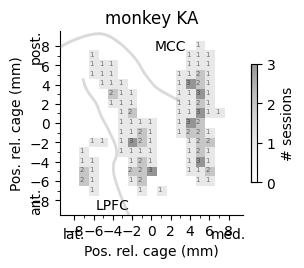

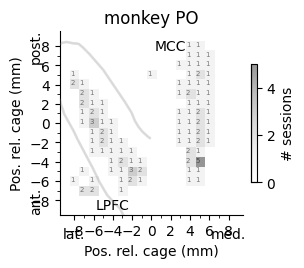

In [11]:
from popy.plotting.plot_cortical_grid import plot_on_cortical_grid

for monkey, df_monkey in recs_df.groupby('monkey'):
    recs_df_to_plot = []
    for session, sub_df in df_monkey.groupby('session'):    
        for area in ['MCC', 'LPFC']:
            # get the data for the current monkey
            if not pd.isna(sub_df[f'coords_{area}'].values[0]):
                
                row = {'monkey': monkey,
                    'session': session,
                    'area': area,
                    'const': 1
                }
                recs_df_to_plot.append(row)

    recs_df_monkey = pd.DataFrame(recs_df_to_plot)
    plot_on_cortical_grid(recs_df_monkey, 'const', title='monkey ' + monkey.upper(),
                            bar_title='# sessions',
                            vmin=0, print_values=True)


## Print stats


In [12]:
# stat
print('ka sessions', len(recs_df.loc[recs_df['monkey'] == 'ka']))
print('po sessions', len(recs_df.loc[recs_df['monkey'] == 'po']))

print(f'ka sessions with interrupted trials: {len(recs_df.loc[(recs_df["monkey"] == "ka") & (recs_df["interrupted_trials"] > 0)])}')
print(f'po sessions with interrupted trials: {len(recs_df.loc[(recs_df["monkey"] == "po") & (recs_df["interrupted_trials"] > 0)])}')

ka sessions 69
po sessions 60
ka sessions with interrupted trials: 12
po sessions with interrupted trials: 25


# 3. Save results

In [13]:
#%% Saving behav info to csv file
fout = os.path.join(RAW_DATA_PATH, "..", "recordings_summary")
recs_df.to_csv(path_or_buf=fout+'.csv', index=False)
#recs_df.to_pickle(fout+'.pickle')

print(f"csv and pickle saved at {fout}.csv (and .csv)")
#print(f"pickle and pickle saved at {fout}.csv (and .pickle)")

csv and pickle saved at /Users/zsombi/ZSOMBI/SBRI/PoPy/data/recordings/../recordings_summary.csv (and .csv)


# 4. Load results

In [14]:
from popy.io_tools import load_metadata
metadata = load_metadata()
metadata

,monkey,recording_day,session,depth,session_of_day,block_len_valid,n_blocks,position_MCC,coords_MCC,position_LPFC,coords_LPFC,LPFC_subregion,MCC_spikes_exist,MCC_file_name,LPFC_spikes_exist,LPFC_file_name,behav_file_name,interrupted_trials,session_complete
0,ka,2020-05-23,230520,7042,1,True,10.0,gm,"(3, 3)",ki,"(-1, -1)",vLPFC,True,spk_dataset_MCC_ka230520_001.txt,False,NaN,ka230520_gmki_7042001.mat,1.0,True
1,ka,2020-06-05,050620,6914,2,True,7.0,ej,"(5, 0)",jf,"(0, -4)",vLPFC,True,spk_dataset_MCC_ka050620_002.txt,True,spk_dataset_LPFC_ka050620_002.txt,ka050620_ejjf_6914002.mat,0.0,True
2,ka,2020-06-08,080620,7621,3,True,9.0,fn,"(4, 4)",kh,"(-1, -2)",vLPFC,True,spk_dataset_MCC_ka080620_003.txt,True,spk_dataset_LPFC_ka080620_003.txt,ka080620_fnkh_7621003.mat,1.0,False
3,ka,2020-06-10,100620,7639,1,True,10.0,el,"(5, 2)",lg,"(-2, -3)",vLPFC,True,spk_dataset_MCC_ka100620_001.txt,True,spk_dataset_LPFC_ka100620_001.txt,ka100620_ellg_7639001.mat,0.0,True
4,ka,2020-06-16,160620,8565,1,True,10.0,go,"(3, 5)",lj,"(-2, 0)",vLPFC,True,spk_dataset_MCC_ka160620_001.txt,True,spk_dataset_LPFC_ka160620_001.txt,ka160620_golj_8565001.mat,1.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,po,2022-07-20,200722,5782,2,True,9.0,di,"(6, -1)",le,"(-2, -5)",vLPFC,True,spk_dataset_MCC_po200722_002.txt,True,spk_dataset_LPFC_po200722_002.txt,po200722_dile_5782002.mat,0.0,True
125,po,2022-07-28,280722,5869,2,True,11.0,gh,"(3, -2)",pg,"(-6, -3)",vLPFC,True,spk_dataset_MCC_po280722_002.txt,True,spk_dataset_LPFC_po280722_002.txt,po280722_ghpg_5869002.mat,1.0,True
126,po,2022-08-09,090822,5184,3,True,7.0,gp,"(3, 6)",ne,"(-4, -5)",vLPFC,True,spk_dataset_MCC_po090822_003.txt,True,spk_dataset_LPFC_po090822_003.txt,po090822_gpne_5184003.mat,0.0,True
127,po,2022-08-31,310822,5522,1,True,10.0,gj,"(3, 0)",ld,"(-2, -6)",vLPFC,True,spk_dataset_MCC_po310822_001.txt,True,spk_dataset_LPFC_po310822_001.txt,po310822_gjld_5522001.mat,2.0,True
